In [58]:
# Notwendige Bibliotheken importieren
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV

## Retrieve Data

In [59]:
# Laden der Daten
train = pd.read_csv('train.csv')

## Clean & Explore

In [60]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [61]:
# Fehlende Werte
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna('S')
train['Fare'] = train['Fare'].fillna(train['Fare'].mean())

# Zuordnung kategorischer Variablen zu ganzen Zahlen
train['Sex'] = train['Sex'].map({'male': 1, 'female': 0}).astype(int)
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
train['Embarked'] = train['Embarked'].map(embarked_mapping).astype(int)

## Prepare & Transform

In [62]:
# Vereinfachtes Feature-Engineering
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)

In [63]:
# Vorbereiten der Daten für die Modellierung
X = train.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
y = train['Survived']

In [64]:
# Aufteilung der Daten in Trainings- und Testsätze
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Develop & Train Model

In [65]:
# Definieren und Anpassen des Entscheidungsbaummodells
model = tree.DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

## Validate & Evaluate Model

In [66]:
# Vorhersagen für den Testsatz treffen
y_pred = model.predict(X_test)

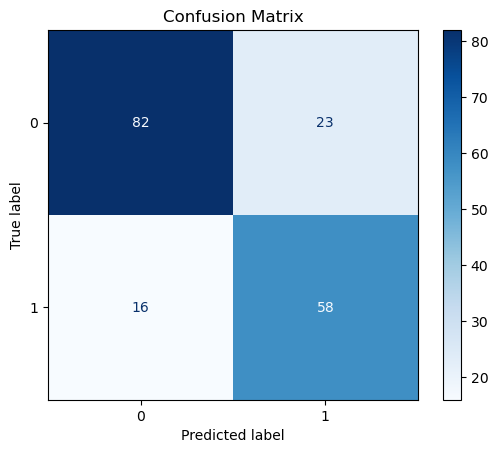

In [67]:
# Konfusionsmatrix für erstes Modell
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [68]:
# Berechnen der Metriken für jede Klasse und zusammengefasst
report = classification_report(y_test, y_pred, target_names=['Gestorben', 'Überlebt'])

# Drucken des Berichts
print(report)

              precision    recall  f1-score   support

   Gestorben       0.84      0.78      0.81       105
    Überlebt       0.72      0.78      0.75        74

    accuracy                           0.78       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.78      0.78       179



In [106]:
# Parameterbereich für GridSearch
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'random_state': [1]  # Setzen des Seeds für den Decision Tree
}

In [107]:
# Erstellen des Klassifikators fürs Tuning
model = tree.DecisionTreeClassifier()

In [108]:
# Erstellen des GridSearchCV-Objekts
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', verbose=1)  

In [109]:
# Modelltuning
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20],
                         'random_state': [1]},
             scoring='f1', verbose=1)

In [110]:
# Beste Parameter und beste Schätzung ausgeben
print("Beste Parameter:", grid_search.best_params_)
print("Bestes Modell:", grid_search.best_estimator_)

Beste Parameter: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'random_state': 1}
Bestes Modell: DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=1)


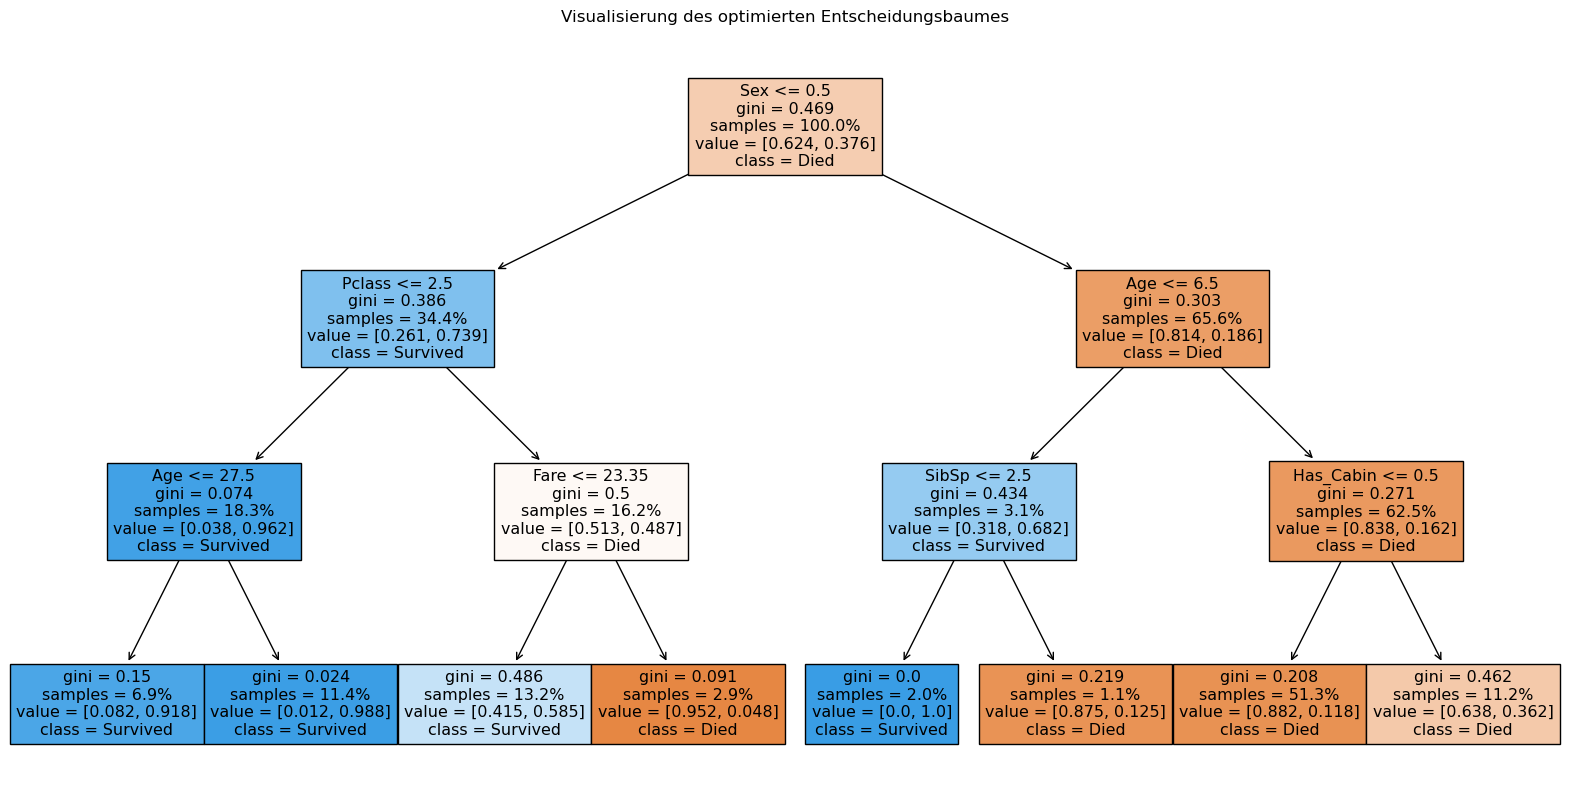

In [111]:
# Visualisieren des Entscheidungsbaumes
plt.figure(figsize=(20, 10))
tree.plot_tree(grid_search.best_estimator_, filled=True, feature_names=X_train.columns.tolist(), class_names=['Died', 'Survived'], proportion=True)
plt.title('Visualisierung des optimierten Entscheidungsbaumes')
plt.show()

In [112]:
# Vorhersagen mit dem besten Modell
y_pred_best = grid_search.best_estimator_.predict(X_test)

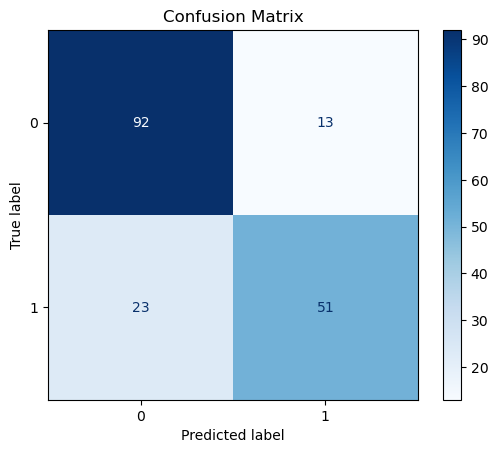

In [113]:
# Konfusionsmatrix für bestes Modell
conf_matrix = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [114]:
# Ausführlicher Bericht für bestes Modell
report = classification_report(y_test, y_pred_best, target_names=['Died', 'Survived'])
print("Klassifikationsbericht:\n", report)

Klassifikationsbericht:
               precision    recall  f1-score   support

        Died       0.80      0.88      0.84       105
    Survived       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

